# Loading Data

## Dataset creation

In [71]:
from nlp import load_dataset
dataset = load_dataset("snli")

df1 = pd.DataFrame(dataset['train'])

df2 = pd.DataFrame(dataset['test'])

new_df = df1.append(df2, ignore_index=True)
new_df.head(3)

new_df['lang_abv'] = 'eng'
new_df['language'] = 'English'
new_df.head(3)

,hypothesis,label,premise,lang_abv,language
0,A person is training his horse for a competition.,1,A person on a horse jumps over a broken down a...,eng,English
1,"A person is at a diner, ordering an omelette.",2,A person on a horse jumps over a broken down a...,eng,English
2,"A person is outdoors, on a horse.",0,A person on a horse jumps over a broken down a...,eng,English


## Model Creation

In [4]:
from transformers import RobertaConfig, RobertaModel

configuration = RobertaConfig()
model = RobertaModel(configuration)
configuration = model.config

In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../../project_watson/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../../project_watson/data/test.csv
../../project_watson/data/train.csv
../../project_watson/data/sample_submission.csv


In [50]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
import os
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [3]:
import tensorflow as tf

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [52]:
train = pd.read_csv("../../project_watson/data/train.csv")

In [53]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

In [7]:
explode = []
for i in range(len(labels)):
    if labels[i] == 'English':
        explode.append(0.1)
    else:
        explode.append(0.2)
explode = tuple(explode)

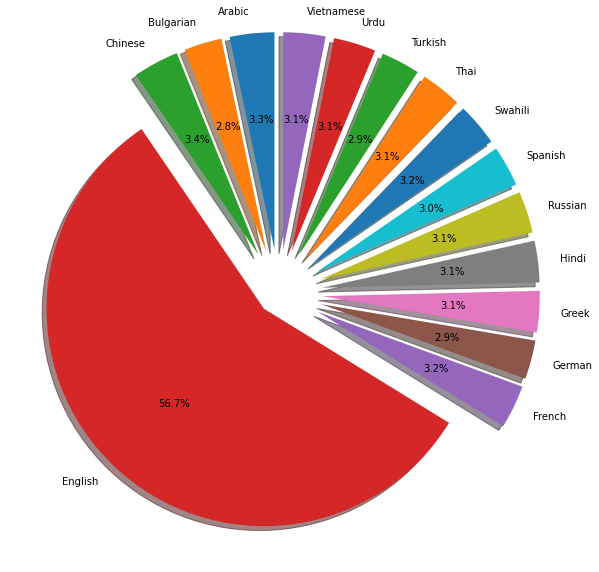

In [8]:
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%', shadow=True, startangle=90, explode = explode)
plt.show()

# Starting exo

In [9]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)



In [10]:
def bert_encode(hypotheses, premises, tokenizer):

    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [11]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [12]:
max_len = 50

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
with strategy.scope():
    model = build_model()
    model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]            

In [14]:
es = EarlyStopping(monitor='val_accuracy', patience=10)
model.fit(train_input, train.label.values, epochs = 20, verbose = 2, batch_size = 32, validation_split = 0.3, callbacks = [es])

Epoch 1/20
266/266 - 76s - loss: 0.9654 - accuracy: 0.5288 - val_loss: 0.8133 - val_accuracy: 0.6419
Epoch 2/20
266/266 - 31s - loss: 0.7349 - accuracy: 0.6887 - val_loss: 0.7872 - val_accuracy: 0.6576
Epoch 3/20
266/266 - 31s - loss: 0.5374 - accuracy: 0.7839 - val_loss: 0.8839 - val_accuracy: 0.6628
Epoch 4/20
266/266 - 31s - loss: 0.3497 - accuracy: 0.8675 - val_loss: 1.1377 - val_accuracy: 0.6493
Epoch 5/20
266/266 - 32s - loss: 0.2166 - accuracy: 0.9191 - val_loss: 1.1787 - val_accuracy: 0.6455
Epoch 6/20
266/266 - 31s - loss: 0.1339 - accuracy: 0.9491 - val_loss: 1.5244 - val_accuracy: 0.6430
Epoch 7/20
266/266 - 31s - loss: 0.0903 - accuracy: 0.9679 - val_loss: 1.7183 - val_accuracy: 0.6449
Epoch 8/20
266/266 - 32s - loss: 0.0814 - accuracy: 0.9718 - val_loss: 1.7664 - val_accuracy: 0.6460
Epoch 9/20
266/266 - 31s - loss: 0.0507 - accuracy: 0.9823 - val_loss: 2.0775 - val_accuracy: 0.6304
Epoch 10/20
266/266 - 31s - loss: 0.0466 - accuracy: 0.9843 - val_loss: 2.0145 - val_accura

In [15]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [16]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [17]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
predictions

[2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 1,


In [18]:
submission = test.id.copy().to_frame()
submission

,id
0,c6d58c3f69
1,cefcc82292
2,e98005252c
3,58518c10ba
4,c32b0d16df
...,...
5190,5f90dd59b0
5191,f357a04e86
5192,1f0ea92118
5193,0407b48afb


In [19]:
submission['prediction'] = predictions

In [20]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,2
4,c32b0d16df,0


In [21]:
submission.to_csv("submission.csv", index = False)